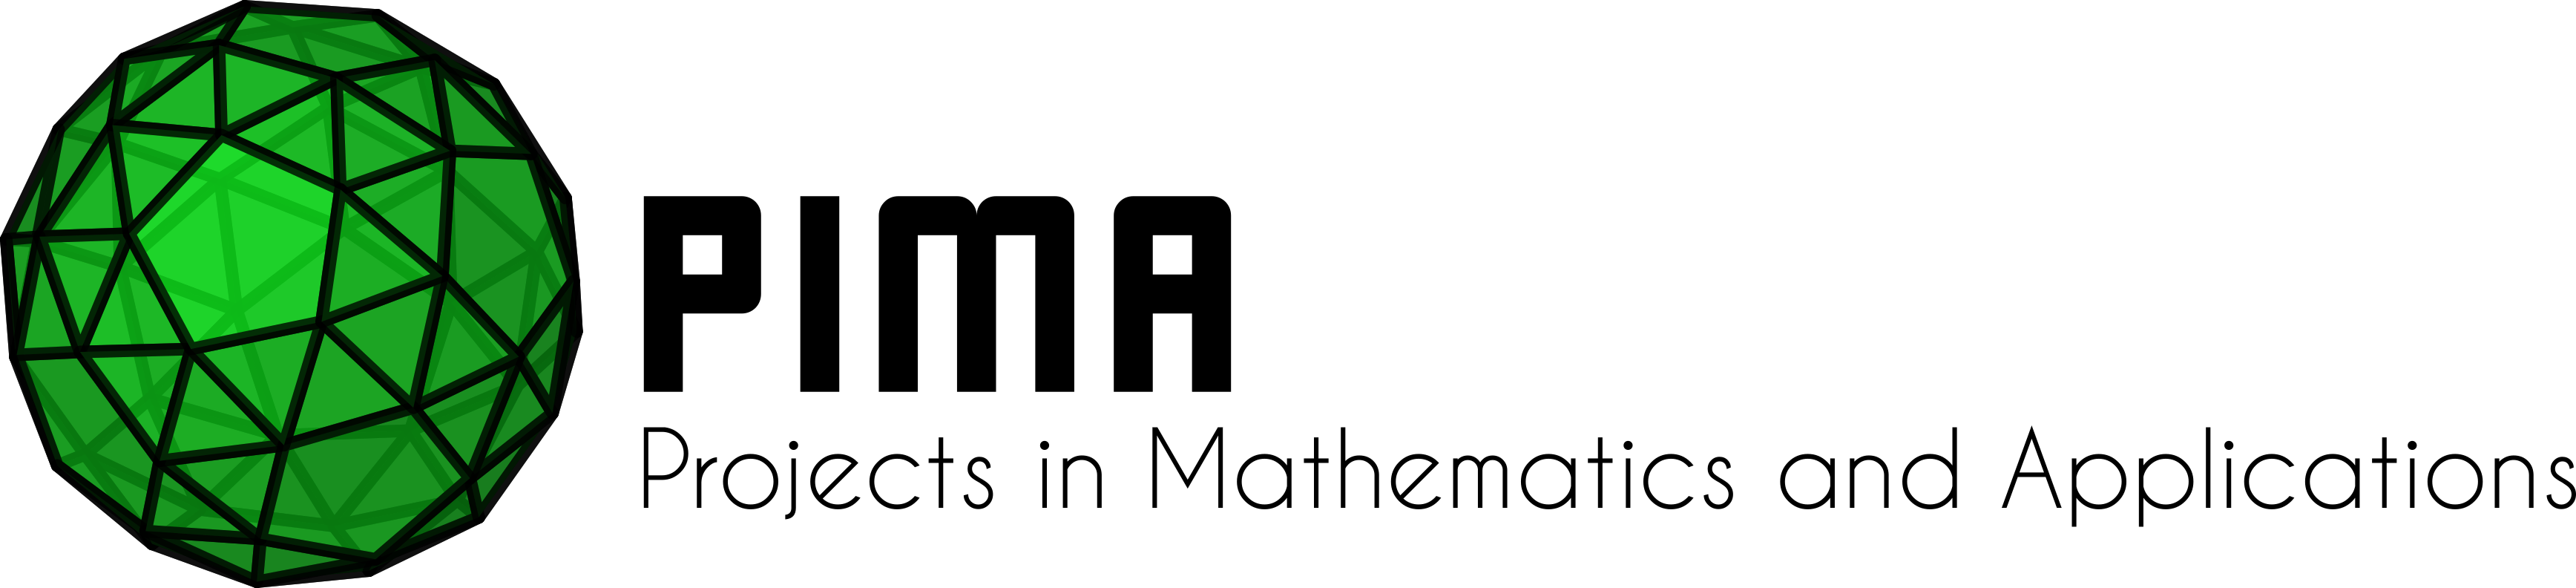

# Bài tập lập trình: Máy Boltzmann hạn chế

In [1]:
# Không cần chỉnh ô này
import os
import numpy as np
import random
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt

def show_and_save(img, file_name):
    """
    Lưu và trình diễn hình ảnh
    Args:
        img (Tensor): Hình ảnh
        file_name (Str): Nơi lưu
    """
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    f = "./%s.png" % file_name
    plt.imshow(npimg, cmap='gray')
    plt.imsave(f, npimg)

def train(model, train_loader, n_epochs=20, lr=0.005):
    """Huấn luyện mô hình tạo sinh
    Args:
        model: Mô hình.
        train_loader (DataLoader)
        n_epochs (int, optional): Số lượng epoch huấn luyện. Mặc định là 20.
        lr (Float, optional): Tốc độ học. Mặc định là 0.01.
    Returns:
        Mô hình đã huấn luyện
    """
    train_op = optim.Adam(model.parameters(), lr)
    model.train()
    for epoch in tqdm(range(n_epochs)):
        loss_ = []
        for _, (data, target) in enumerate(train_loader):
            loss = model.get_loss(data.view(-1, 784))
            loss_.append(loss.item())
            train_op.zero_grad()
            loss.backward()
            train_op.step()
        print('Epoch %d\t Loss=%.4f' % (epoch, np.mean(loss_)))
    return model

seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [63]:
class RBM(nn.Module):
    """Máy Boltzmann hạn chế (RBM)
    Args:
        n_vis (int, optional): Kích thước của lớp quan sát được. Mặc định là 784.
        n_hid (int, optional): Kích thước của lớp ẩn. Mặc định là 128.
        k (int, optional): Số lần lấy mẫu Gibbs. Mặc định là 1.
    """

    def __init__(self, n_vis=784, n_hid=128, k=1):
        """Khởi tạo RBM."""
        super(RBM, self).__init__()
        # Khởi tạo ma trận trọng số W và thiên vị v, h
        self.W = nn.Parameter(torch.randn(n_hid, n_vis) * 0.1)  # (n_hid, n_vis) = (128, 784)
        self.v = nn.Parameter(torch.zeros(n_vis))  # Thiên vị cho lớp quan sát (784,)
        self.h = nn.Parameter(torch.zeros(n_hid))  # Thiên vị cho lớp ẩn (128,)
        self.k = k  # Số bước lấy mẫu Gibbs

    def visible_to_hidden(self, v):
        """Lấy mẫu ẩn có điều kiện từ các dữ liệu quan sát được
        Args:
            v (Tensor): Các biến từ lớp quan sát được (batch_size, n_vis)
        Returns:
            Tensor: Mẫu từ lớp ẩn (batch_size, n_hid)
        """
        p_h = torch.sigmoid(F.linear(v, self.W, self.h))
        return torch.bernoulli(p_h)

    def hidden_to_visible(self, h):
        """Lấy mẫu quan sát được có điều kiện từ các dữ liệu ẩn
        Args:
            h (Tensor): Các biến từ lớp ẩn (batch_size, n_hid)
        Returns:
            Tensor: Mẫu từ lớp quan sát được (batch_size, n_vis)
        """
        p_v = torch.sigmoid(F.linear(h, self.W.t(), self.v))
        return torch.bernoulli(p_v)

    def free_energy(self, v, reduction='mean'):
        """Hàm năng lượng tự do
        Args:
            v (Tensor): Các mẫu quan sát được (batch_size, n_vis)
            reduction ("mean" hoặc "none"): lựa chọn cách biểu diễn hàm năng lượng
        Returns:
            energy (FloatTensor): Giá trị của hàm năng lượng tự do
        """
        vbias_term = v.mv(self.v)
        wv = F.linear(v, self.W, self.h)
        # Công thức ổn định cho log(1 + exp(x))
        hidden_term = torch.log(1 + torch.exp(-torch.abs(wv))) + torch.max(wv, torch.zeros_like(wv))
        hidden_term = hidden_term.sum(1)
        energy = -vbias_term - hidden_term
        return energy.mean() if reduction == 'mean' else energy

    def forward(self, v):
        """Xác định các mẫu thực tế và tạo sinh
        Args:
            v (Tensor): Mẫu thực tế trên lớp quan sát được (batch_size, n_vis)
        Returns:
            (Tensor, Tensor): Các mẫu thực tế và tạo sinh
        """
        # Lấy mẫu ẩn từ v
        h = self.visible_to_hidden(v)
        v_gibbs = v
        for _ in range(self.k):
            h_gibbs = self.visible_to_hidden(v_gibbs)
            v_gibbs = self.hidden_to_visible(h_gibbs)
        return v, v_gibbs

    def get_loss(self, inputs):
        """Xác định mất mát khi huấn luyện mô hình theo phân kỳ tương phản.
        Args:
            inputs (Tensor): Dữ liệu đầu vào (batch_size, n_vis)
        Returns:
            Tensor: Giá trị hàm mất mát
        """
        # Tính năng lượng tự do của dữ liệu gốc
        v, v_gibbs = self.forward(inputs)
        loss = self.free_energy(v) - self.free_energy(v_gibbs)
        return loss.mean()

    @torch.no_grad()
    def pseudo_likelihood(self, v):
        """Không được chỉnh hàm này"""
        # Randomly corrupt one feature in each sample in v.
        ind = (np.arange(v.shape[0]), np.random.randint(0, v.shape[1], v.shape[0]))
        v_ = v.clone()
        v_[ind] = 1 - v_[ind]
        fe = self.free_energy(v, reduction='none')
        fe_ = self.free_energy(v_, reduction='none')
        m = torch.nn.LogSigmoid()
        score = v.shape[1] * m(fe_ - fe)
        return score


In [64]:
# Không cần chỉnh ô này
train_dataset = datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor(), lambda x: (x > 0).float()]
    )
)
test_dataset = datasets.MNIST('./data',
    train=False,
    transform = transforms.Compose(
        [transforms.ToTensor(), lambda x: (x > 0).float()]
    )
)

batch_size = 128
n_hid = 128
n_vis = 784
n_epochs = 20
lr = 0.01
rbm_ckpt_fn = 'model_rbm_seed2025.pt'

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [65]:
#Không cần chỉnh ô này
if not os.path.exists(rbm_ckpt_fn):
    model_rbm = RBM(n_vis=n_vis, n_hid=n_hid, k=1)
    model_rbm = train(model_rbm, train_loader, n_epochs=n_epochs, lr=lr)
    # save model, do not change the filename.
    torch.save(model_rbm.state_dict(), rbm_ckpt_fn)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0	 Loss=-15.8134
Epoch 1	 Loss=-9.1730
Epoch 2	 Loss=-5.6726
Epoch 3	 Loss=-3.9568
Epoch 4	 Loss=-2.7865
Epoch 5	 Loss=-2.0755
Epoch 6	 Loss=-1.3764
Epoch 7	 Loss=-0.8400
Epoch 8	 Loss=-0.5588
Epoch 9	 Loss=-0.2685
Epoch 10	 Loss=-0.0669
Epoch 11	 Loss=0.2249
Epoch 12	 Loss=0.3747
Epoch 13	 Loss=0.6236
Epoch 14	 Loss=0.7231
Epoch 15	 Loss=0.8972
Epoch 16	 Loss=1.0225
Epoch 17	 Loss=1.1819
Epoch 18	 Loss=1.2616
Epoch 19	 Loss=1.3244


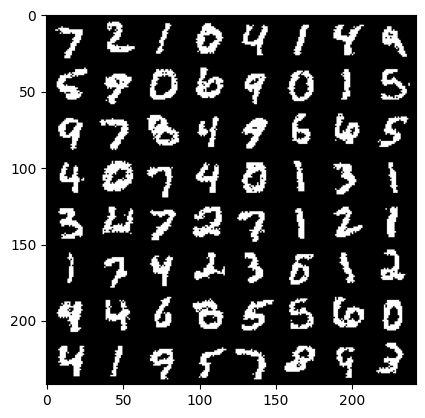

In [66]:
# Minh họa các mẫu sinh ra từ mô hình
model_rbm.eval()
vis_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
images = next(iter(vis_loader))[0]
v, v_gibbs = model_rbm(images.view(-1, 784))
show_and_save(make_grid(v_gibbs.view(64, 1, 28, 28).data), 'rbm_fake')